In [29]:
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams.update({
#     'font.family': 'sans-serif',  # Use sans-serif as a fallback
#     'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
#     'font.size': 10,
#     'axes.labelsize': 9,
#     'axes.titlesize': 11,
#     'xtick.labelsize': 8,
#     'ytick.labelsize': 8,
#     'legend.fontsize': 8,
#     'figure.titlesize': 12,
    
#     'axes.grid': False,
#     'grid.linestyle': '-',  # Solid line
#     'grid.linewidth': 0.4,  # Very thin grid lines
#     'grid.color': '#CCCCCC',  # Light gray grid
    
#     'axes.axisbelow': True,
#     'figure.figsize': (8, 4),  # Standard publication-friendly figure size
#     'figure.dpi': 100, # Smaller preview
#     # 'figure.dpi': 300, 
    
#     'lines.linewidth': 1.0,  # Consistent line thickness
#     'lines.markersize': 4,  # Consistent marker size

#     'figure.facecolor': 'white',  # Background color of the figure
#     'figure.edgecolor': 'white',   # Edge color of the figure
# })
import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    #'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'legend.title_fontsize': 14,  
    
    'axes.grid': False,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
OUTPUT_DIR = "reorder_plots"
import os
def morton_encode(x, y, nbits=16):
    morton_code = 0
    for i in range(nbits):
        morton_code |= ((y >> i) & 1) << (2 * i + 1)
        morton_code |= ((x >> i) & 1) << (2 * i)
    return morton_code

def morton_encode_str(x, y, nbits=16):
    morton_code = morton_encode(x, y, nbits)
    return format(morton_code, f'0{nbits*2}b')

def hilbert_encode(x, y, nbits=16):
    """
    Encode a 2D point to its Hilbert curve distance.

    Parameters:
        bits (int): Order of the Hilbert curve.
        pt (tuple or list): 2D point as (x, y).

    Returns:
        int: Hilbert curve distance.
    """
    x, y = y, x
    d = 0
    s = 1 << (nbits - 1)  # equivalent to (1 << bits) // 2
    while s:
        rx = 1 if (x & s) > 0 else 0
        ry = 1 if (y & s) > 0 else 0
        d += s * s * ((3 * rx) ^ ry)
        if ry == 0:
            if rx == 1:
                x = s - 1 - x
                y = s - 1 - y
            # Swap x and y
            x, y = y, x
        s //= 2
    return d

def hilbert_encode_str(x, y, nbits=16):
    hilbert_code = hilbert_encode(x, y, nbits)
    return format(hilbert_code, f'0{nbits*2}b')




000000
000010
001000
001010
000001
000011
001001
001011
000100
000110
001100
001110
000101
000111
001101
001111
100000
101000
100100
101100
010000
011000
010100
011100
110000
Plot saved as reorder_plots/morton_quadtree.pdf


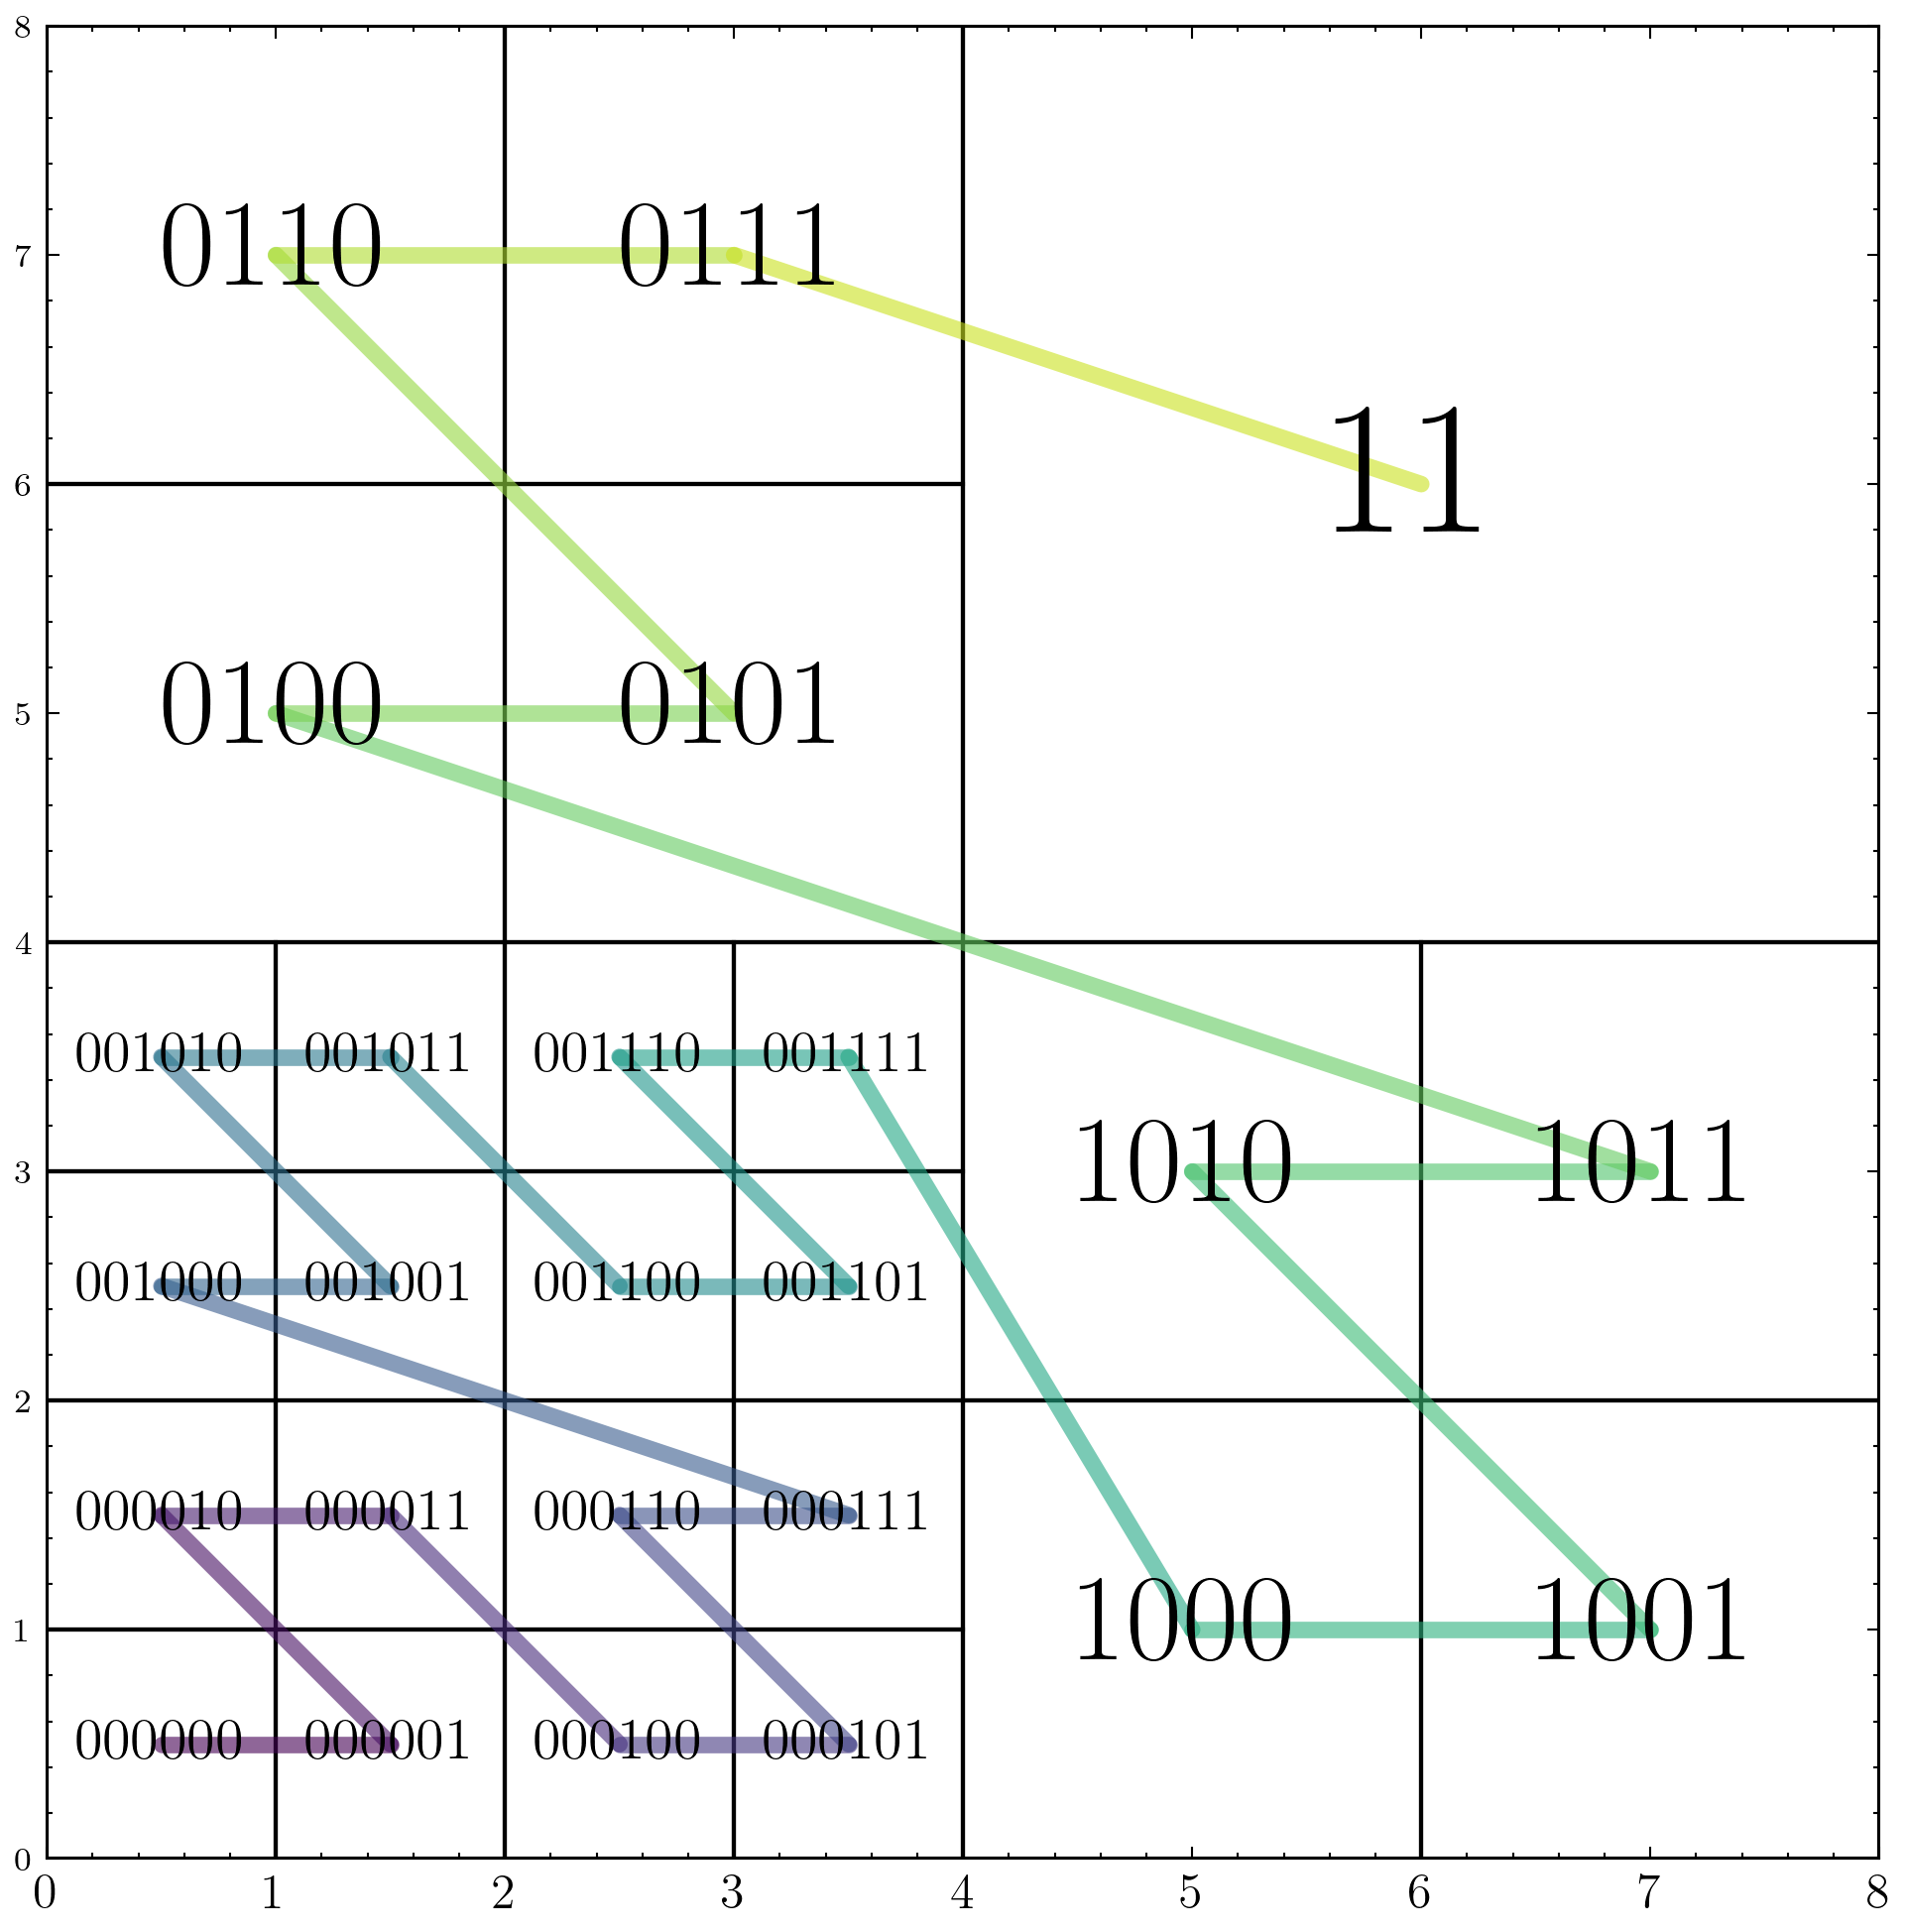

In [31]:

def plot_quadtree_subdivision(subdivisions_level, mode="morton"):
    grid_size = max(subdivisions_level)**2 * 2
    nbits = int(np.ceil(np.log2(grid_size)))
    # print("grid size: ", grid_size, " nbits: ", nbits)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal', adjustable='box')

    z_curve_path = []

    for i, subdivision in enumerate(subdivisions_level):
        if i == 0:
            start_x, start_y = 0, 0
        elif i == 1:
            start_x, start_y = grid_size // 2, 0
        elif i == 2:
            start_x, start_y = 0, grid_size // 2
        elif i == 3:
            start_x, start_y = grid_size // 2, grid_size // 2

        suboctants = 2**subdivision
        step_size = (grid_size // 2) // suboctants
        # print("i = ", i, " subdiv = ", subdivision, "octants = ", suboctants, " step size: ", step_size)
        
        for x in range(suboctants):
            for y in range(suboctants):
                ax.add_patch(plt.Rectangle(
                    (start_x + x * step_size, start_y + y * step_size), 
                    step_size, step_size, edgecolor='black', facecolor='none', lw=1
                ))

                rel_x = y * (2**(nbits - subdivision - 1)) + start_x
                rel_y = x * (2**(nbits - subdivision - 1)) + start_y
                code_str = 0
                if i == 0 or mode == "morton":
                    code_str = morton_encode_str(rel_y, rel_x, nbits) if mode == "morton" else hilbert_encode_str(rel_y, rel_x, nbits)
                else:
                    code_str = morton_encode_str(rel_x, rel_y, nbits) if mode == "morton" else hilbert_encode_str(rel_x, rel_y, nbits)
                # tweaks xd
                print(code_str)
                if mode != "morton":
                    if code_str == "011110":
                        code_str = "010100"
                    elif code_str == "010100":
                        code_str = "011100"
                    elif code_str == "111100":
                        code_str = "110100"
                    elif code_str == "110110":
                        code_str = "111100"
                ax.text(start_x + x * step_size + step_size / 2, 
                        start_y + y * step_size + step_size / 2, 
                        code_str[:(subdivision+1)*2], 
                        color='black', 
                        ha='center', 
                        va='center', 
                        fontsize=14 + 16 * (2 - subdivision))
                code = morton_encode(rel_x, rel_y, nbits) if mode == "morton" else hilbert_encode(rel_x, rel_y, nbits)
                z_curve_path.append((rel_x + step_size / 2, rel_y + step_size / 2, code))

    z_curve_path.sort(key=lambda point: point[2])
    # print(z_curve_path)

    z_curve_x = [point[0] for point in z_curve_path]
    z_curve_y = [point[1] for point in z_curve_path]

    # Create a list of segments with the color mapped
    segments = []
    colors = []

    for i in range(len(z_curve_x) - 1):
        segments.append([(z_curve_x[i], z_curve_y[i]), (z_curve_x[i + 1], z_curve_y[i + 1])])
        colors.append(i / len(z_curve_x))  # Normalized index for color mapping

    # Create a LineCollection to color each segment
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1), linewidth=4, alpha=0.6, capstyle="round")
    lc.set_array(np.array(colors))  # Apply color values to the segments
    ax.add_collection(lc)
    pdf_path = os.path.join(OUTPUT_DIR, f"{mode}_quadtree.pdf")
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight', facecolor='white', format='pdf')
    print(f"Plot saved as {pdf_path}")
    plt.show()

plot_quadtree_subdivision(subdivisions_level=[2, 1, 1, 0], mode = "morton")

000000
000011
000100
000101
000001
000010
000111
000110
001110
001101
001000
001001
001111
001100
001011
001010
010000
010100
011110
011000
111010
110110
111100
110010
100000
Plot saved as reorder_plots/hilbert_quadtree.pdf


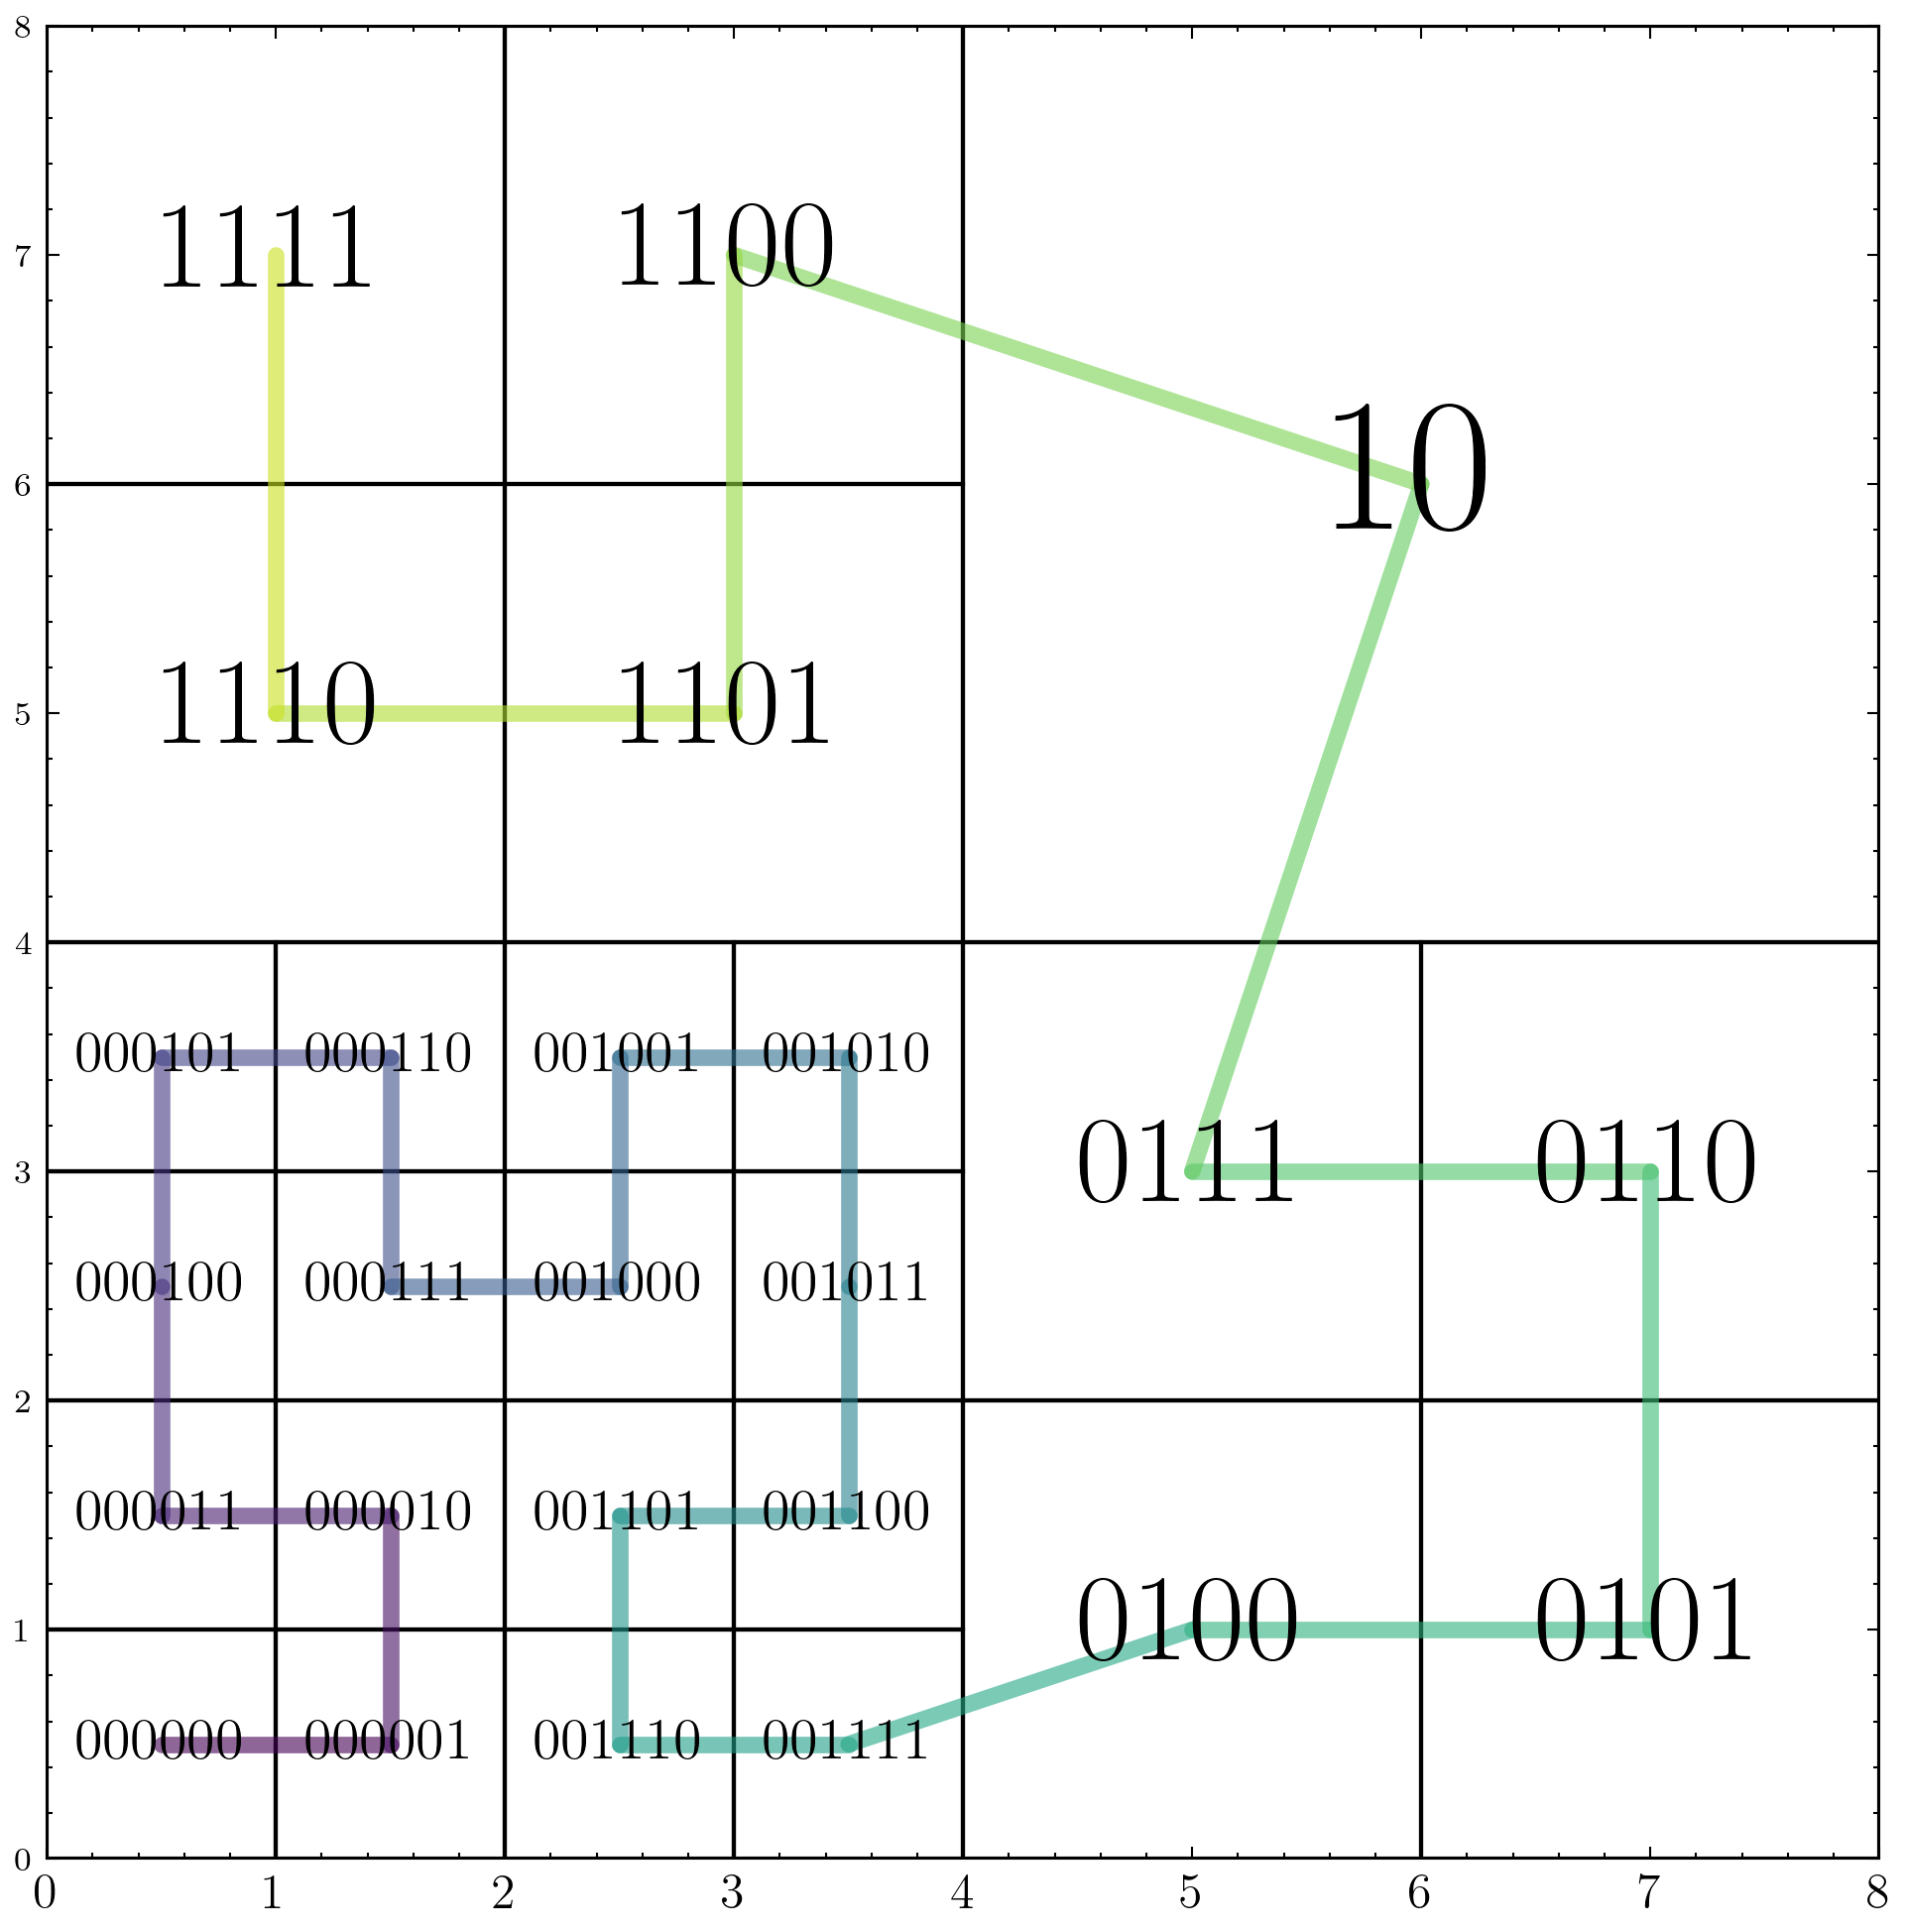

In [32]:
plot_quadtree_subdivision(subdivisions_level=[2, 1, 1, 0], mode = "hilbert")